# Interfacing with Stan
This notebook explains how it is possible to interface with [Stan](https://mc-stan.org/) to make use of their awesome library for log-probability calculations, gradient calculation (via autodiff) and their large zoo of probability distributions.

One thing to be mindful of is that the interface below only allows the log probability to be accessed from Stan objects up to an additive constant. Another is that Stan operates on the unconstrained scale, so the PINTS interface to Stan passes and receives parameter draws on this scale.

In this notebook, we use two examples:

- a simple Gaussian example
- the [Eight Schools example](http://pints.readthedocs.io/en/latest/toy/eight_schools.html) 

## Gaussian example

In [1]:
import os
os.chdir("../..")
import pints
import pints.toy
import pints.interfaces
import pystan
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.stats

In [2]:
code = '''
        data {
  int<lower=0> N;
  real y[N];
}
parameters {
  real mu;
  real sigma; 
}
model {
  y ~ normal(mu, sigma);
}'''

In [3]:
data = {'N':10, 'y':np.random.normal(size=10)}
stanmodel = pints.interfaces.StanLogPDF(stan_code=code,
                                        stan_data=data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_694e923a257c6a10986d5789af2b176d NOW.


Stan model compiled and runs ok...ignore various warnings.


/usr/local/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


In [4]:
# initialise
xs = [np.random.uniform(size=2,low=0.2, high=1) for chain in range(4)]
    
mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.3)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.5       0.5       0.5        0:00.0
3     244    0.6       0.6       0.6       0.6        0:00.0
400   32004  0.99      0.988     0.988     0.985      0:02.5
800   64004  0.994     0.993     0.993     0.993      0:05.1
1200  96004  0.994     0.993     0.993     0.993      0:07.6
1600  128004  0.995     0.994     0.994382  0.995      0:10.1
2000  159924  0.996     0.995     0.995     0.995      0:12.6
Halting: Maximum number of iterations (2000) reached.
Done!


In [5]:
results = pints.MCMCSummary(chains=full_chains, time=(end-start),
                            parameter_names=stanmodel.names())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
mu       0.44    0.27    -0.11   0.28   0.44   0.61   1.00     1.00    2666.67  210.99
sigma    0.80    0.25    0.49    0.64   0.75   0.91   1.39     1.00    2515.82  199.05


### Constrained $\sigma$
We now illustrate how constraining $\sigma$ results in a changed behaviour. Stan always samples on the unconstrained scale: it is able to do so because its parameters are always defined with bounds in the `parameters` block. (See https://mc-stan.org/docs/2_26/reference-manual/variable-transforms-chapter.html for a description of the different transforms applied to constrained variables.) The PINTS interface to Stan always supplies parameters on the unconstrained scale. In the below Stan code block, we put a lower bound on $\sigma$. Seeing this, Stan performs a log-transformation on this variable. So the draws we obtain via the Stan interface will be unconstrained.

In [6]:
code1 = '''
        data {
  int<lower=0> N;
  real y[N];
}
parameters {
  real mu;
  real<lower=0> sigma; 
}
model {
  y ~ normal(mu, sigma);
}'''

In [7]:
stanmodel1 = pints.interfaces.StanLogPDF(stan_code=code1,
                                        stan_data=data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb4bff9ca90afdba8fce72619f7509f9 NOW.


Stan model compiled and runs ok...ignore various warnings.


Since the $\sigma$ variable is now unconstrained, we are free to pass unconstrained initial values to the sampler.

In [8]:
xs = [np.random.uniform(size=2,low=-1, high=1) for chain in range(4)]

mcmc = pints.MCMCController(stanmodel1, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.3)

start = time.time()
# Run!
print('Running...')
full_chains1 = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.5       0.5       0.5        0:00.0
3     244    0.6       0.6       0.6       0.6        0:00.0
400   32004  0.993     0.995     0.99      0.99       0:02.5
800   64004  0.996     0.996     0.995     0.994      0:05.1
1200  96004  0.998     0.997     0.997     0.996      0:07.6
1600  128004  0.998     0.998     0.998     0.997      0:10.2
2000  159924  0.999     0.998     0.998001  0.998      0:12.7
Halting: Maximum number of iterations (2000) reached.
Done!


To compare the draws across the two methods, we need to convert back to the constrained space. Note, that the Stan interface takes care of the Jacobian transformations, so we only need to apply the inverse transformation to the samples (the `exp` function).

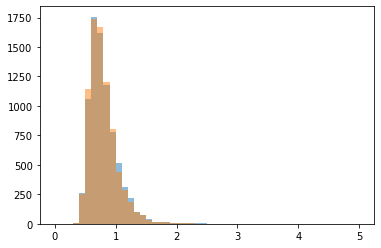

In [9]:
plt.hist(np.vstack(full_chains)[:, 1], bins=np.arange(0, 5 + 0.1, 0.1), alpha=0.5)
plt.hist(np.exp(np.vstack(full_chains1)[:, 1]), bins=np.arange(0, 5 + 0.1, 0.1), alpha=0.5)
plt.show()

## 8 Schools

We now illustrate how to use the Stan interface to sample from the notorious 8 schools model. First, we use the PINTS [eight schools toy model](https://github.com/pints-team/pints/blob/master/examples/toy/distribution-eight-schools.ipynb) to give us the requisite data.

In [10]:
model = pints.toy.EightSchoolsLogPDF()
model.data()

{'J': 8,
 'y': [28, 8, -3, 7, -1, 1, 18, 12],
 'sigma': [15, 10, 16, 11, 9, 11, 10, 18]}

### Centered model

We first use PINTS' interface to Stan's models to compile the Stan code for the `centered` model and define a PINTS model. We also pickle the model so that it can be reloaded for later use.

In [11]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
"""

In [12]:
# instantiate Pints version of Stan model
stanmodel = pints.interfaces.StanLogPDF(stan_code=code,
                                        stan_data=model.data(),
                                        pickle_filename="test_model.pkl")

Stan model compiled and runs ok...ignore various warnings.


Run the [HMC](../sampling/hamiltonian-mcmc.ipynb) sampler using this model.

In [13]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
    
mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(1.0)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.5       0.5       0.5        0:00.0
3     244    0.6       0.6       0.6       0.6        0:00.0
400   32004  0.988     0.973     0.973     0.953      0:03.1
800   64004  0.975     0.983     0.978     0.97       0:06.2
1200  96004  0.981     0.984193  0.98      0.973      0:09.3
1600  128004  0.981     0.966     0.981     0.973      0:12.4
2000  160004  0.983     0.969031  0.98002   0.975025   0:15.6
2400  192004  0.965     0.965     0.978     0.974      0:18.7
2800  224004  0.969     0.964     0.975     0.971449   0:21.9
3200  256004  0.967     0.965     0.975     0.973      0:25.0
3600  288004  0.967     0.967     0.976     0.975      0:28.1
4000  319924  0.967     0.961     0.973     0.974 

Let's print the results of inference. Note here that $\tau$ is on the log-scale, since Stan see its lower about and applies this transformation.

In [14]:
results = pints.MCMCSummary(chains=full_chains, time=(end-start),
                            parameter_names=stanmodel.names())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mu       4.23    3.21    -2.17   2.05   4.29   6.51   10.20    1.02    238.30  7.62
tau      0.97    0.98    -1.26   0.37   1.09   1.68   2.59     1.01    246.33  7.88
theta.1  6.32    5.90    -3.32   2.68   5.77   8.99   20.64    1.01    235.10  7.52
theta.2  4.68    4.90    -5.15   1.85   4.68   7.53   14.49    1.02    244.80  7.83
theta.3  3.51    5.85    -10.87  0.90   4.06   6.94   12.97    1.03    211.72  6.77
theta.4  4.55    4.89    -5.30   1.57   4.54   7.44   14.22    1.01    319.57  10.22
theta.5  3.32    4.59    -6.84   0.53   3.71   6.49   11.32    1.01    420.62  13.45
theta.6  3.88    4.85    -7.00   1.11   4.16   6.98   12.69    1.01    330.20  10.56
theta.7  6.65    5.27    -1.84   3.20   6.05   9.24   19.58    1.01    217.84  6.97
theta.8  4.89    4.88    -4.62   1.80   4.87   7.76   1

The wandering chains here illustrate how difficult inference is for this model.

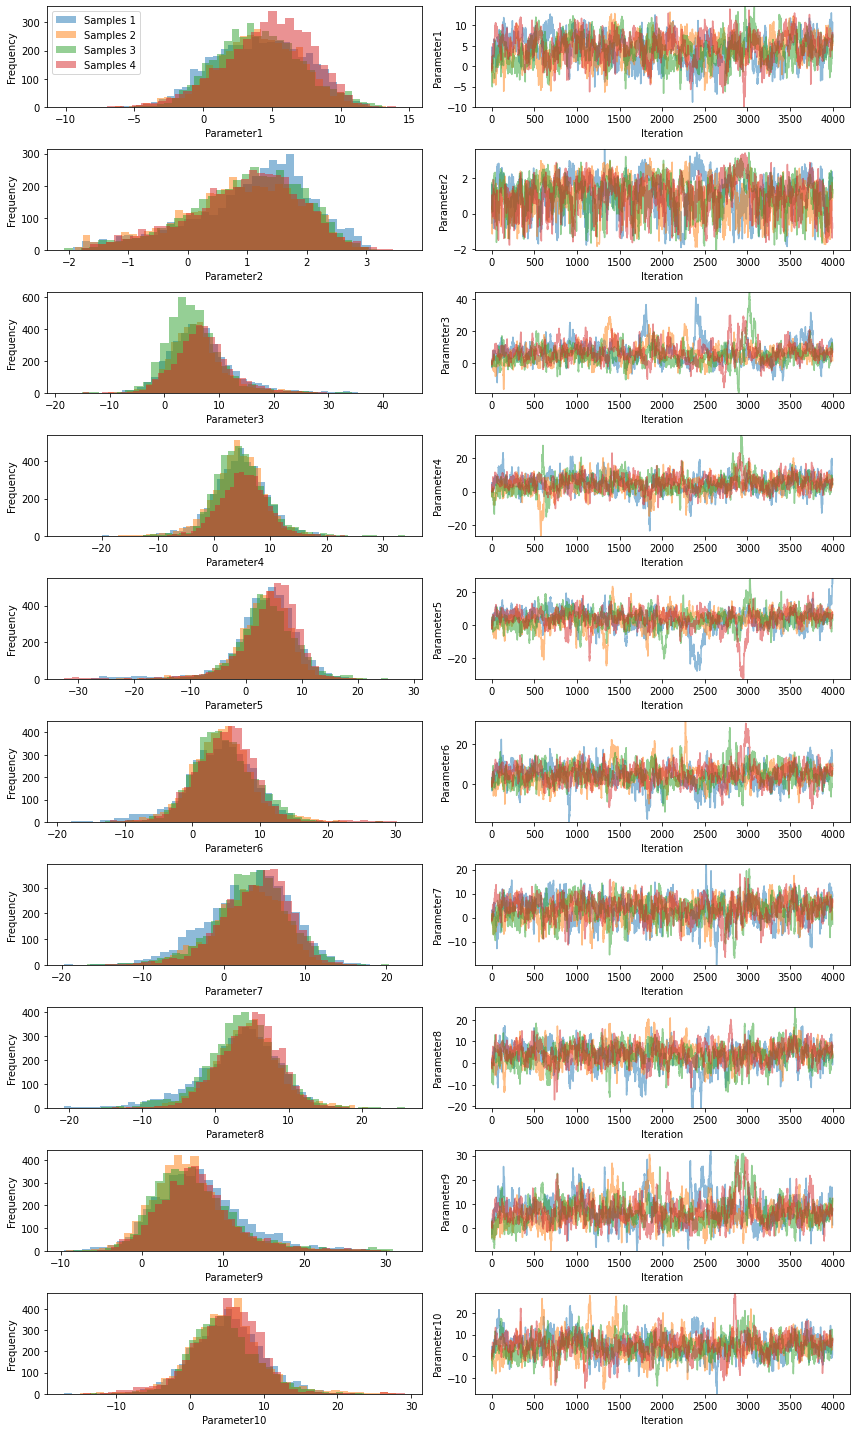

In [15]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()

Just to hammer home the differences between Stan's log probability and Pints': we can compare them for sets of parameter values.

In [16]:
params = np.random.uniform(size=10)

pints_parameters = np.copy(params)
stan_parameters = np.copy(params)
# because tau is on log-scale for Stan model
stan_parameters[1] = np.log(stan_parameters[1])

pintsmodel = pints.toy.EightSchoolsLogPDF()

print(str("Stan log prob: " + str(stanmodel(stan_parameters))))
print(str("Pints log prob: " + str(pintsmodel(pints_parameters))))

Stan log prob: -2.2920477858584962
Pints log prob: -41.25379055239393


But the changes in parameter values should evoke proportional changes in the log-posterior.

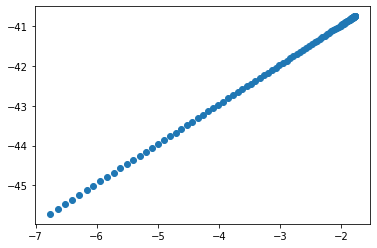

In [17]:
xs = np.linspace(0, 1, 100)
vals_stan = []
vals_pints = []
for x in xs:
    stan_parameters[0] = x
    pints_parameters[0] = x
    vals_stan.append(stanmodel(stan_parameters))
    vals_pints.append(pintsmodel(pints_parameters))
plt.plot(vals_stan, vals_pints, 'o')
plt.show()

Sensitivities however are the same because the constants disappear.

In [18]:
p1, dp1 = stanmodel.evaluateS1(stan_parameters)
p2, dp2 = pintsmodel.evaluateS1(pints_parameters)

print(str("Stan d log(prob)/dmu: " + str(dp1[0])))
print(str("Pints d log(prob)/dmu: " + str(dp2[0])))

Stan d log(prob)/dmu: -2.555911865279742
Pints d log(prob)/dmu: -2.5559118652797417


## Non-centered model

To speed things up, we can move to Stan's non-centered parameterisation. (Pints also has a version of this model: ) This model introduces auxillary variables $\tilde{\theta}_j$ which ensure the joint distribution: $p(\mu,\tau, \boldsymbol{\theta})$ remains the same, but is easier to sample from.

In [19]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
"""

Instantiate Pints version of non-centered Stan model.

In [20]:
stanmodel = pints.interfaces.StanLogPDF(stan_code=code,
                                        stan_data=model.data())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f8f9e8bb354ab461436bb51d935571d NOW.


Stan model compiled and runs ok...ignore various warnings.


/usr/local/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


Retry sampling, this time with the non-centered parameterisation.

In [21]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]

mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.5       0.5       0.5        0:00.0
3     244    0.6       0.6       0.6       0.6        0:00.0
400   32004  0.995     0.995     0.995     0.995      0:03.2
800   64004  0.998     0.998     0.998     0.998      0:06.5
1200  96004  0.998     0.998     0.998     0.998      0:09.9
1600  128004  0.999     0.999     0.999     0.999      0:13.4
2000  160004  0.999001  0.999001  0.999001  0.999001   0:16.7
2400  192004  0.999     0.999     0.999     0.999      0:19.9
2800  224004  0.999     0.999     0.999     0.999      0:23.1
3200  256004  0.999     0.999     0.999     0.999      0:26.4
3600  288004  0.999     0.999     0.999     0.999      0:29.6
4000  319924  1         1         1         1     

Get back original parameter values: $\theta_j = \mu + \tilde{\theta}_j \tau$.

In [22]:
full_chains_transformed = []
for i in range(len(full_chains)):
    mu = full_chains[i][:, 0]
    tau = full_chains[i][:, 1]
    theta_tilde_j = full_chains[i][:, 2:]
    full_chains_transformed.append(
        np.concatenate((np.transpose(np.vstack((mu, tau))),
                        mu[:, np.newaxis] + (theta_tilde_j * tau[:, np.newaxis])),axis=1).tolist())
full_chains_transformed = np.array(full_chains_transformed)

Aaaaahh, that's better...

In [23]:
results = pints.MCMCSummary(chains=full_chains_transformed,
                            time=(end-start), parameter_names=stanmodel.names())
print(results)

param          mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mu             4.23    3.47    -2.26   1.80   4.06   6.64   11.23    1.07    83.41   2.53
tau            0.85    1.05    -1.67   0.28   1.02   1.60   2.46     1.01    414.07  12.57
theta_tilde.1  4.72    3.61    -2.12   2.21   4.59   7.22   12.06    1.06    96.02   2.91
theta_tilde.2  4.38    3.53    -2.19   1.93   4.21   6.74   11.55    1.06    93.88   2.85
theta_tilde.3  4.10    3.61    -2.60   1.57   3.96   6.56   11.36    1.06    97.39   2.96
theta_tilde.4  4.26    3.57    -2.35   1.80   4.14   6.69   11.46    1.07    100.34  3.05
theta_tilde.5  4.06    3.53    -2.55   1.60   3.86   6.44   11.30    1.07    93.45   2.84
theta_tilde.6  4.14    3.54    -2.42   1.62   4.01   6.55   11.29    1.06    94.77   2.88
theta_tilde.7  4.76    3.55    -1.95   2.27   4.65   7.19   11.88    1.06    96.1

...much more efficient sampling!

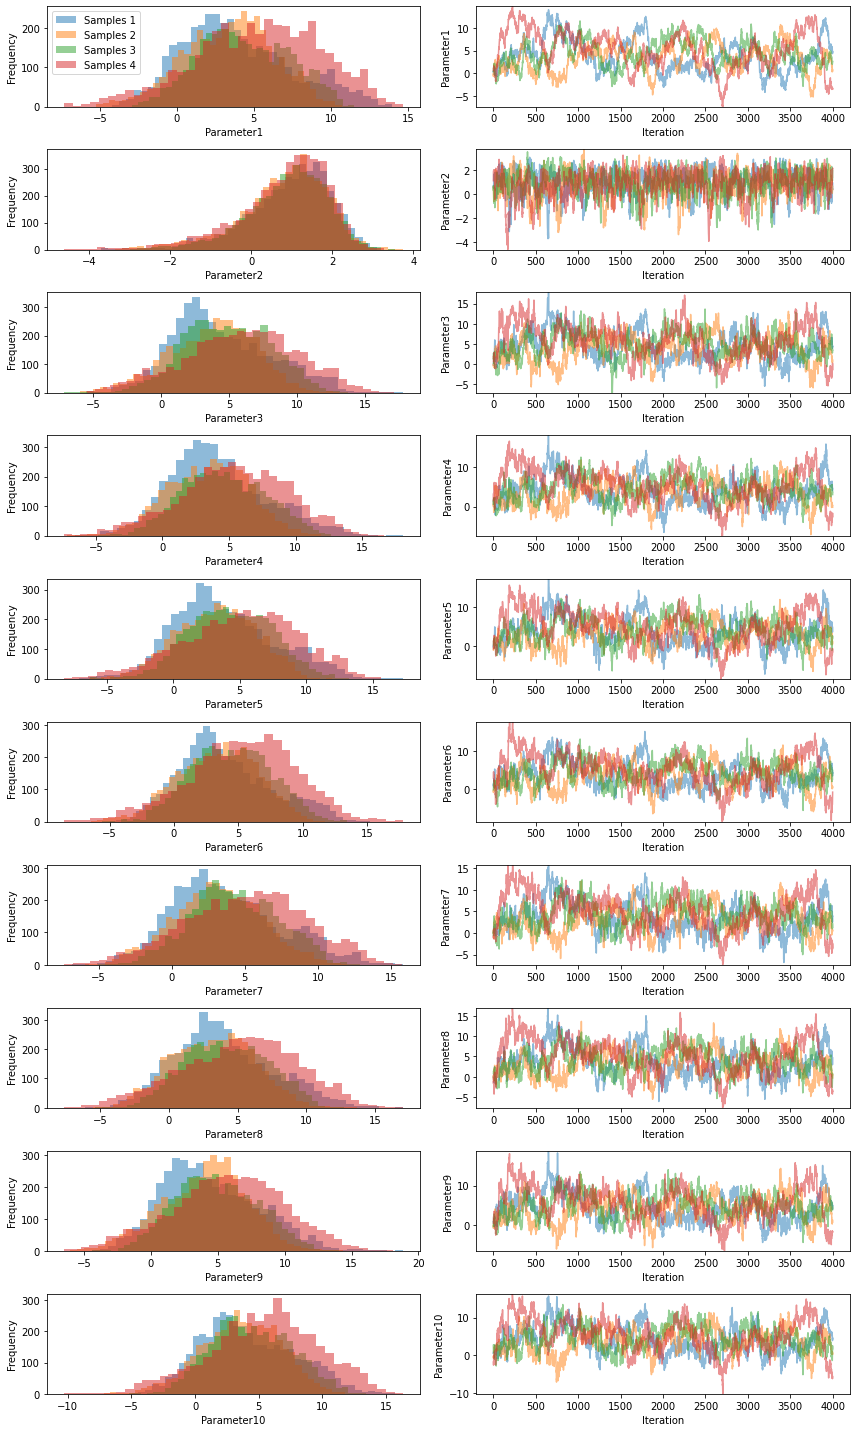

In [24]:
import pints.plot
pints.plot.trace(full_chains_transformed)
plt.show()